# Practical Application III: Comparing Classifiers

**Overview**: In this practical application, your goal is to compare the performance of the classifiers we encountered in this section, namely K Nearest Neighbor, Logistic Regression, Decision Trees, and Support Vector Machines.  We will utilize a dataset related to marketing bank products over the telephone.  



### Getting Started

Our dataset comes from the UCI Machine Learning repository [link](https://archive.ics.uci.edu/ml/datasets/bank+marketing).  The data is from a Portugese banking institution and is a collection of the results of multiple marketing campaigns.  We will make use of the article accompanying the dataset [here](CRISP-DM-BANK.pdf) for more information on the data and features.



### Problem 1: Understanding the Data

To gain a better understanding of the data, please read the information provided in the UCI link above, and examine the **Materials and Methods** section of the paper.  How many marketing campaigns does this data represent?

In [1]:
# There are a total of 17 campaigns that occurred between May 2008 and November 2010 with an 8% success rate that subscribed to a bank term deposit.

### Problem 2: Read in the Data

Use pandas to read in the dataset `bank-additional-full.csv` and assign to a meaningful variable name.

In [2]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder, PolynomialFeatures
from sklearn.compose import make_column_selector, make_column_transformer
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression, RidgeClassifier, Lasso
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.feature_selection import SelectFromModel
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.compose import ColumnTransformer
import time

In [3]:
df = pd.read_csv('data/bank-additional-full.csv', sep = ';')

In [4]:
df.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


In [5]:
# renmae y to subscribe to easier field identifier
df = df.rename(columns={'y': 'subscribe'})

### Problem 3: Understanding the Features


Examine the data description below, and determine if any of the features are missing values or need to be coerced to a different data type.


```
Input variables:
# bank client data:
1 - age (numeric)
2 - job : type of job (categorical: 'admin.','blue-collar','entrepreneur','housemaid','management','retired','self-employed','services','student','technician','unemployed','unknown')
3 - marital : marital status (categorical: 'divorced','married','single','unknown'; note: 'divorced' means divorced or widowed)
4 - education (categorical: 'basic.4y','basic.6y','basic.9y','high.school','illiterate','professional.course','university.degree','unknown')
5 - default: has credit in default? (categorical: 'no','yes','unknown')
6 - housing: has housing loan? (categorical: 'no','yes','unknown')
7 - loan: has personal loan? (categorical: 'no','yes','unknown')
# related with the last contact of the current campaign:
8 - contact: contact communication type (categorical: 'cellular','telephone')
9 - month: last contact month of year (categorical: 'jan', 'feb', 'mar', ..., 'nov', 'dec')
10 - day_of_week: last contact day of the week (categorical: 'mon','tue','wed','thu','fri')
11 - duration: last contact duration, in seconds (numeric). Important note: this attribute highly affects the output target (e.g., if duration=0 then y='no'). Yet, the duration is not known before a call is performed. Also, after the end of the call y is obviously known. Thus, this input should only be included for benchmark purposes and should be discarded if the intention is to have a realistic predictive model.
# other attributes:
12 - campaign: number of contacts performed during this campaign and for this client (numeric, includes last contact)
13 - pdays: number of days that passed by after the client was last contacted from a previous campaign (numeric; 999 means client was not previously contacted)
14 - previous: number of contacts performed before this campaign and for this client (numeric)
15 - poutcome: outcome of the previous marketing campaign (categorical: 'failure','nonexistent','success')
# social and economic context attributes
16 - emp.var.rate: employment variation rate - quarterly indicator (numeric)
17 - cons.price.idx: consumer price index - monthly indicator (numeric)
18 - cons.conf.idx: consumer confidence index - monthly indicator (numeric)
19 - euribor3m: euribor 3 month rate - daily indicator (numeric)
20 - nr.employed: number of employees - quarterly indicator (numeric)

Output variable (desired target):
21 - y - has the client subscribed a term deposit? (binary: 'yes','no')
```



### Problem 4: Understanding the Task

After examining the description and data, your goal now is to clearly state the *Business Objective* of the task.  State the objective below.

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41188 entries, 0 to 41187
Data columns (total 21 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             41188 non-null  int64  
 1   job             41188 non-null  object 
 2   marital         41188 non-null  object 
 3   education       41188 non-null  object 
 4   default         41188 non-null  object 
 5   housing         41188 non-null  object 
 6   loan            41188 non-null  object 
 7   contact         41188 non-null  object 
 8   month           41188 non-null  object 
 9   day_of_week     41188 non-null  object 
 10  duration        41188 non-null  int64  
 11  campaign        41188 non-null  int64  
 12  pdays           41188 non-null  int64  
 13  previous        41188 non-null  int64  
 14  poutcome        41188 non-null  object 
 15  emp.var.rate    41188 non-null  float64
 16  cons.price.idx  41188 non-null  float64
 17  cons.conf.idx   41188 non-null 

In [7]:
## Business Objective - Likley hood that a client would subscribe to a bank term deposit.

### Problem 5: Engineering Features

Now that you understand your business objective, we will build a basic model to get started.  Before we can do this, we must work to encode the data.  Using just the bank information features, prepare the features and target column for modeling with appropriate encoding and transformations.

In [8]:
# Define features (X) and target (y)
X = df.drop('subscribe', axis=1)
y = df['subscribe']

In [9]:
# Select features by datatype.
# Scale and encode transformation.
selector = make_column_selector(dtype_include=object)
transformer = make_column_transformer((OneHotEncoder(drop = 'first'), selector),
                                     remainder = StandardScaler())
# ----------------------------------------------------------------------------------
categorical_columns = X.select_dtypes(include=['object']).columns.tolist()
numerical_columns = X.select_dtypes(include=['float64', 'int64']).columns.tolist()
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_columns),
        ('cat', OneHotEncoder(drop='first'), categorical_columns)
    ])


### Problem 6: Train/Test Split

With your data prepared, split it into a train and test set.

In [10]:
# Split data into testing and training datasets.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### Problem 7: A Baseline Model

Before we build our first model, we want to establish a baseline.  What is the baseline performance that our classifier should aim to beat?

In [11]:
# the baseline we should aim to beat is .886502
y_test.value_counts(normalize = True)


subscribe
no     0.886502
yes    0.113498
Name: proportion, dtype: float64

### Problem 8: A Simple Model

Use Logistic Regression to build a basic model on your data.  

In [12]:
# Basic logicigic Regression model yeields a accuracy score of .91
# The accuracy score is above the baseline score of .88
extractor = SelectFromModel(LogisticRegression(penalty='l1', solver = 'liblinear' ,random_state = 42))
lgr_pipe = Pipeline([('transformer', transformer),
                    ('selector', extractor),
                    ('lgr', LogisticRegression(random_state=42, max_iter = 1000))])

lgr_pipe.fit(X_train, y_train)

lgr_score = lgr_pipe.score(X_test, y_test)


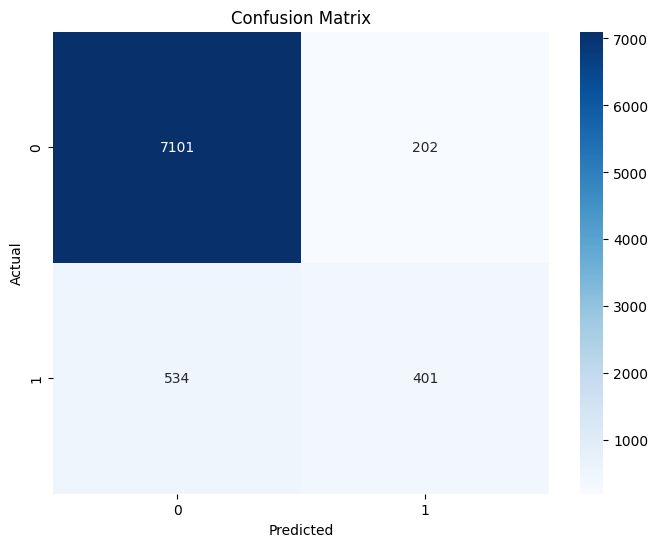

In [13]:
# Confusion matric - shows that there our current logistic Regessions are 534 false negatives and 202 false positives.

preds = lgr_pipe.predict(X_test)
conf_matrix = confusion_matrix(y_test, preds)

# Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=[0, 1], yticklabels=[0, 1])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Subscribe Matrix')
plt.show()

### Problem 9: Score the Model

What is the accuracy of your model?

In [14]:
lgr_score

0.9106579266812334

### Problem 10: Model Comparisons

Now, we aim to compare the performance of the Logistic Regression model to our KNN algorithm, Decision Tree, and SVM models.  Using the default settings for each of the models, fit and score each.  Also, be sure to compare the fit time of each of the models.  Present your findings in a `DataFrame` similar to that below:

| Model | Train Time | Train Accuracy | Test Accuracy |
| ----- | ---------- | -------------  | -----------   |
|     |    |.     |.     |

In [15]:
#Model Comparion of the accuracy score of the Logistic Regression model to our KNN algorithm, Decision Tree, and SVM model.

models = {
    'knn': (KNeighborsClassifier(), {'knn__n_neighbors': [5]}),
    'logisticregression': (LogisticRegression(max_iter=100), {'logisticregression__C': [1]}),
    'svc': (SVC(), {'svc__C': [1], 'svc__kernel': ['rbf']}),
    'decisiontreeclassifier': (DecisionTreeClassifier(), {'decisiontreeclassifier__max_depth': [None]})
}

In [37]:

results = []

for name, (model, params) in models.items():
    # Create a pipeline
    pipeline = Pipeline([
        ('preprocessor', preprocessor),
        (name, model)
    ])
   
    # Perform grid search
    grid_search = GridSearchCV(pipeline, param_grid=params, cv=5, n_jobs=-1)
    
    # Fit the model and time it
    start_time = time.time()
    grid_search.fit(X_train, y_train)
    fit_time = (time.time() - start_time) / len(grid_search.cv_results_['mean_fit_time'])
    
    # Get the best estimator
    best_model = grid_search.best_estimator_
    
    # Evaluate on training and test sets
    train_score = best_model.score(X_train, y_train)
    test_score = best_model.score(X_test, y_test)
    
    # Append the results
    results.append([name, train_score, test_score, fit_time])

# Create the results DataFrame
results_df = pd.DataFrame(results, columns=['model', 'train score', 'test score', 'time'])
results_df.set_index('model', inplace=True)

In [38]:
# Based on comparison using the default classifiers, the accuracy for test is lower in train vs test.
# There is a drop off when it comes to test scores. We are under fitting the model.
# Since only looking at the default classifiers, we may not be getting the optional fit as each run may yield different scores.
# Using the the default clasffiers the results are.
## The Decision Tree Model run time is the quickest of the models with the highest variance between test and train scores.
## The Logistic Regrssion Model is the best model with the default classifiers yielding the 2nd fastest time with the least variance between scores.

results_df

,train score,test score,time
model,,,
knn,0.928589,0.903010,4.267105
logisticregression,0.911836,0.911143,3.611582
svc,0.921700,0.911143,41.856269
decisiontreeclassifier,1.000000,0.884074,0.906606


### Problem 11: Improving the Model

Now that we have some basic models on the board, we want to try to improve these.  Below, we list a few things to explore in this pursuit.

- More feature engineering and exploration.  For example, should we keep the gender feature?  Why or why not?
- Hyperparameter tuning and grid search.  All of our models have additional hyperparameters to tune and explore.  For example the number of neighbors in KNN or the maximum depth of a Decision Tree.  
- Adjust your performance metric

In [39]:
# there's no gender feature to keep or get rid of.
feature_names = lgr_pipe.named_steps['transformer'].get_feature_names_out()
selected_features =feature_names[ [int(i[1:]) for i in lgr_pipe.named_steps['selector'].get_feature_names_out()]]
clean_names = [i.split('__')[-1] for i in selected_features]
coef_df = pd.DataFrame({'feature': clean_names, 'coefs': lgr_pipe.named_steps['lgr'].coef_[0]})
coef_df['coefs'] = coef_df['coefs'].apply(abs)
coef_df = coef_df.sort_values(by = 'coefs', ascending = False)

In [40]:
# the features with the high co-eff showing a strong relationship to the subscribe target field.
coef_df.head()

,feature,coefs
41,emp.var.rate,2.605767
25,month_mar,1.893613
37,duration,1.207256
42,cons.price.idx,1.090576
35,poutcome_success,0.903225


In [41]:
# the features with the lowest co-eff shows that it's not affecting the subscribe target field.
coef_df.tail()

,feature,coefs
15,education_high.school,0.029129
19,loan_yes,0.028688
18,housing_yes,0.018401
12,marital_single,0.014044
36,age,0.003936


In [42]:
# Hypertuning our classifers for the all the models.
models = {
    'knn': (KNeighborsClassifier(), {'knn__n_neighbors': [3, 5, 7]}),
    'logisticregression': (LogisticRegression(max_iter=1000), {'logisticregression__C': [0.1, 1, 10]}),
    'svc': (SVC(), {'svc__C': [0.1, 1, 10], 'svc__kernel': ['linear', 'rbf']}),
    'decisiontreeclassifier': (DecisionTreeClassifier(), {'decisiontreeclassifier__max_depth': [5, 10, 15]})
}

results = []

for name, (model, params) in models.items():
    # Create a pipeline
    pipeline = Pipeline([
        ('preprocessor', preprocessor),
        (name, model)
    ])
    
    # Perform grid search
    grid_search = GridSearchCV(pipeline, param_grid=params, cv=5, n_jobs=-1)
    
    # Fit the model and time it
    start_time = time.time()
    grid_search.fit(X_train, y_train)
    fit_time = (time.time() - start_time) / len(grid_search.cv_results_['mean_fit_time'])
    
    # Get the best estimator
    best_model = grid_search.best_estimator_
    
    # Evaluate on training and test sets
    train_score = best_model.score(X_train, y_train)
    test_score = best_model.score(X_test, y_test)
    
    # Append the results
    results.append([name, train_score, test_score, fit_time])

# Create the results DataFrame
results_df1 = pd.DataFrame(results, columns=['model', 'train score', 'test score', 'time'])
results_df1.set_index('model', inplace=True)

In [43]:
# Based on comparison using tuning the classifers for each model.
# The training and test scores for each model are more closly aligned.
## The Decision Tree Model run time is the quickest of the models with high scores.
results_df1

,train score,test score,time
model,,,
knn,0.924219,0.904467,1.172090
logisticregression,0.911836,0.911143,0.602873
svc,0.921700,0.911143,52.075908
decisiontreeclassifier,0.917420,0.915028,2.406309


##### Questions